## 作業
請詳細閱讀 https://github.com/qqwweee/keras-yolo3 的 readme ，按照 readme 的說明嘗試修改程式碼範例，學會使用 tiny YOLOv3 來做檢測，並且計算其平均 fps 以及觀察其檢測結果。


In [ ]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# # 下載基於 keras 的 yolov3 程式碼
# %cd 'gdrive/My Drive'
# # !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# %cd keras-yolo3

Mounted at /content/gdrive


In [3]:
import os
import subprocess
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights /content/gdrive/MyDrive/keras-yolo3/model_data/yolo.h5")
else:
  print("Model exist")

Model doesn't exist, downloading...
Converting yolov3.weights to yolo.h5...


In [7]:
!python /content/gdrive/MyDrive/keras-yolo3/convert.py /content/gdrive/MyDrive/keras-yolo3/yolov3.cfg /content/gdrive/MyDrive/keras-yolo3/yolov3.weights /content/gdrive/MyDrive/keras-yolo3/model_data/yolo.h5

2024-09-04 13:20:40.626072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 13:20:40.646863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 13:20:40.653331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 13:20:40.667421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 13:20:41.962212: W tensorflow/comp

In [ ]:
# 下載圖片範例，如果已經下載過就可以註解掉
# !wget https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true -O dog.jpg
# !wget https://github.com/pjreddie/darknet/blob/master/data/horses.jpg?raw=true -O horses.jpg

In [8]:
from PIL import Image

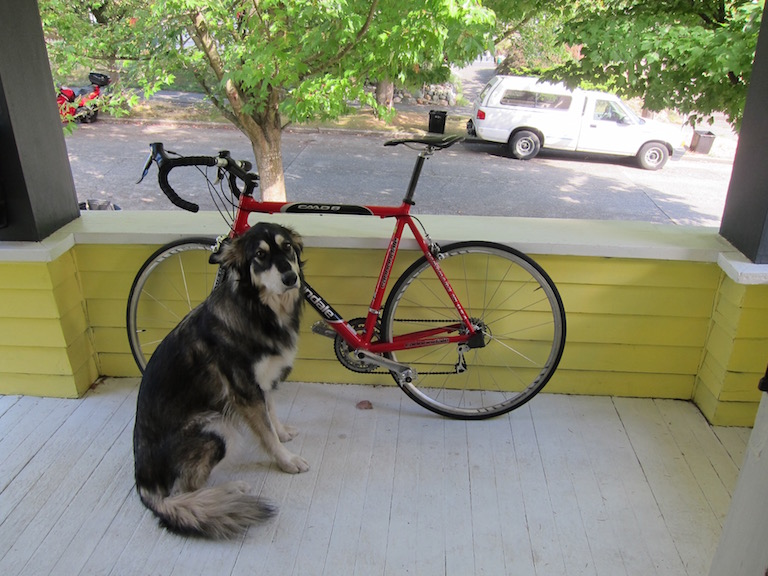

In [10]:
image = Image.open('/content/gdrive/MyDrive/keras-yolo3/dog.jpg') # 讀取範例圖片
image

In [11]:
# 將 yolo.py 所需要的套件載入
import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

ModuleNotFoundError: No module named 'yolo3'

In [ ]:
# 定義 YOLO class
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    # 更改 detect_image 使得其回傳需要的信息
    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        # return out_boxes, out_scores, out_classes
        return image

    def close_session(self):
        self.sess.close()

    # 單純 inference 的 method
    def pure_detect_image(self, image):
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        # print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        return out_boxes, out_scores, out_classes

In [ ]:
yolo = YOLO() # 初始化 YOLO class

In [ ]:
import numpy as np
import time

In [ ]:
start = time.time()
results = yolo.pure_detect_image(image)
end = time.time()
print("single inference took: %.3fs" % (end-start))

In [ ]:
fps = 1 / (end-start)
print("fps: %.3f" % (fps))

In [ ]:
time_eplased = []
for i in range(100):
  start = time.time()
  results = yolo.pure_detect_image(image)
  end = time.time()
  time_eplased.append(end-start)

In [ ]:
avg_fps = 1/np.mean(time_eplased)
print("avg fps: %.3f" % avg_fps)

In [ ]:
!nvidia-smi # 可用來檢測使用什麼 GPU, 在這裡是 Tesla K80

In [ ]:
import time
def fps_test(yolo):
    time_eplased = []

    for i in range(100):
        start = time.time()
        results = yolo.pure_detect_image(image)
        end = time.time()
        time_eplased.append(end-start)

    single_time = time_eplased[0]
    single_fps = 1 / single_time
    avg_fps = 1 / np.mean(time_eplased)
    print(f"single inference took: {single_time:.3f}s")
    print(f"fps: {single_fps:.3f}")
    print(f"avg fps: {avg_fps:.3f}")

    return

In [ ]:
config_dict = {
    'model_path': "model_data/yolov3-tiny.h5",
    'anchors_path': "model_data/tiny_yolo_anchors.txt"
    }
yolo = YOLO(**config_dict)
fps_test(yolo)